# [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

## [Abstract](#abstract)

The Traveling Salesman Problem (TSP) is a **classic problem in [combinatorial optimization](https://en.wikipedia.org/wiki/Combinatorial_optimization)**.

It is the problem of **finding a tour of minimum cost that visits each city exactly once**. The TSP is **NP-hard**. That is, no efficient algorithm is known that finds the optimal solution to the problem for large sets of cities.

## [Exhaustive](#exhaustive-search)
It is a **brute force** algorithm that does not use any information about the problem to find the solution.

- [Heap's Algorithm](#heaps-algorithm)
- [Steinhaus–Johnson–Trotter Algorithm](#sjt-algorithm)

## [Random](#random-search)
Is a **[stochastic optimization](https://en.wikipedia.org/wiki/Stochastic_optimization)** algorithm that does not use any information about the problem to find the solution.

## [Hill Climbing](#hill-climbing-search)
Is a **[local search](https://en.wikipedia.org/wiki/Local_search_(optimization))** algorithm that does not use any information about the problem to find the solution.

----

### Abstract

In this notebook, we're exploring various techniques to solve the [Traveling Salesman Problem (TSP)](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

Our focus is on implementing **exhaustive search**, **random search**, and **hill-climbing algorithms** to tackle this problem. Additionally, **we'll visualize the results of each iteration**, **analyze their performance**, and **draw insightful conclusions**.

By delving into these algorithms and their outcomes, we aim to enhance our understanding of optimization techniques and their practical applications.

In [1]:
import random
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# constants
CITIES = 7  # number of cities
GENERATIONS = 100  # number of generations to run
MUTATION_RATE = 0.01  # mutation rate (0.01 = 1%) 1/100

In these part I've define some functions to help us to manage all the algorithms and to visualize the results.

In [2]:
def generate_cities(cities: int) -> np.ndarray:
    """Generate cities with random x and y coordinates."""
    return np.random.rand(cities, 2)

def get_distance_between_cities(city1: np.ndarray, city2: np.ndarray) -> float:
    """Get distance between two cities."""
    return np.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

def print_distances(cities: np.ndarray, solution: np.ndarray) -> None:
    """Print distances between cities according to the order in the solution."""
    distances = [get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(len(cities) - 1)]
    print(f"Solution:  {solution}\nDistance: {sum(distances)}")  # print solution and total distance
    [print(f"{solution[i-1]} -> {solution[i]}: {distances[i]}") for i in range(len(cities) - 1)]  # print distances between cities

def plot_solution(title: str, cities: np.ndarray, solution: np.ndarray) -> None:
    """Plot solution."""
    plt.figure(figsize=(12, 12))
    [plt.plot([cities[solution[i]][0], cities[solution[i + 1]][0]], [cities[solution[i]][1], cities[solution[i + 1]][1]], c='blue') for i in range(len(cities) - 1)]
    # plt.plot([cities[solution[-1]][0], cities[solution[0]][0]], [cities[solution[-1]][1], cities[solution[0]][1]], c='blue')  # plot a line between the last and the first city
    plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)
    plt.title(title)
    plt.show()

def get_fitness(cities: np.ndarray, solution) -> float:
    """
    Get fitness of a solution.
    In most cases, fitness is the inverse of the total distance.
    In this case we will use the total distance as fitness. This because we want to minimize the distance.    
    """
    # distances = [get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)]
    # return sum(distances)  # return fitness
    return sum([get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)])

def plot_fitness(title: str, fitness: list) -> None:
    """Plot fitness."""
    plt.plot(fitness)
    plt.title(title)
    plt.show()

def crossover(parents: np.ndarray) -> np.ndarray:
    """Crossover parents to produce offspring."""
    return np.concatenate((parents[0][:CITIES // 2], [city for city in parents[1] if city not in parents[0][:CITIES // 2]]))

def mutate(offspring: np.ndarray) -> np.ndarray:
    """
    Mutate offspring.
    Shuffle offspring (mutation) if mutation rate is reached.
    """
    if np.random.rand() < MUTATION_RATE:  # if mutation rate is reached
        offspring = np.random.permutation(offspring)  # shuffle offspring (mutation)
    return offspring  # return offspring


[[0.07377874 0.18504362]
 [0.3292727  0.9419589 ]
 [0.15991286 0.82188695]
 [0.13377223 0.7830142 ]
 [0.96613515 0.04633398]
 [0.06615936 0.00579689]
 [0.19902241 0.69345578]]


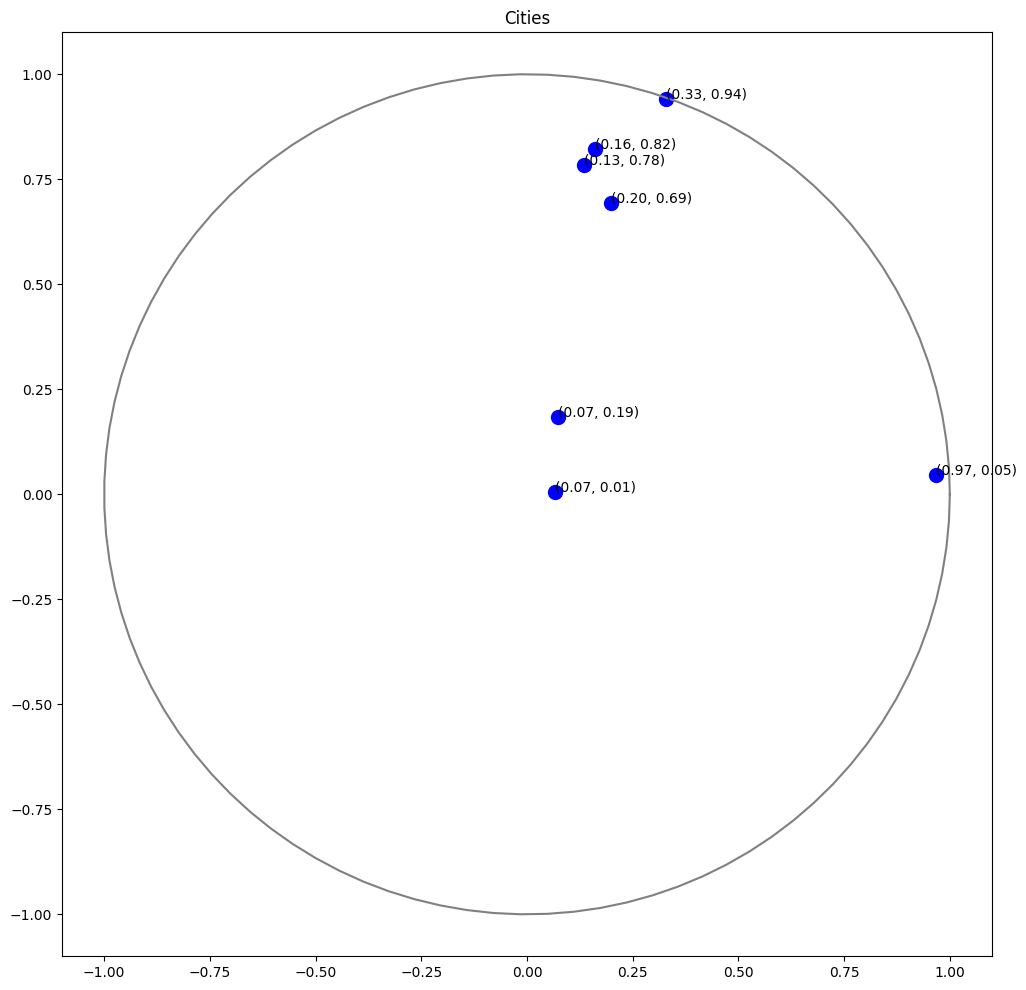

In [3]:
cities = generate_cities(CITIES)  # generate cities
# cities = np.array([[np.cos(2 * np.pi * i / CITIES), np.sin(2 * np.pi * i / CITIES)] for i in range(CITIES)])
print(cities)

# draw the circle
plt.figure(figsize=(12, 12))
plt.plot(np.cos(2 * np.pi * np.linspace(0, 1, 100)), np.sin(2 * np.pi * np.linspace(0, 1, 100)), c='gray')  # draw the circle
plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)  # draw the cities
[plt.annotate(f"({city[0]:.2f}, {city[1]:.2f})", (city[0], city[1]), fontsize=10) for _, city in enumerate(cities)]  # add the coordinates to the cities
plt.title("Cities")
plt.show()

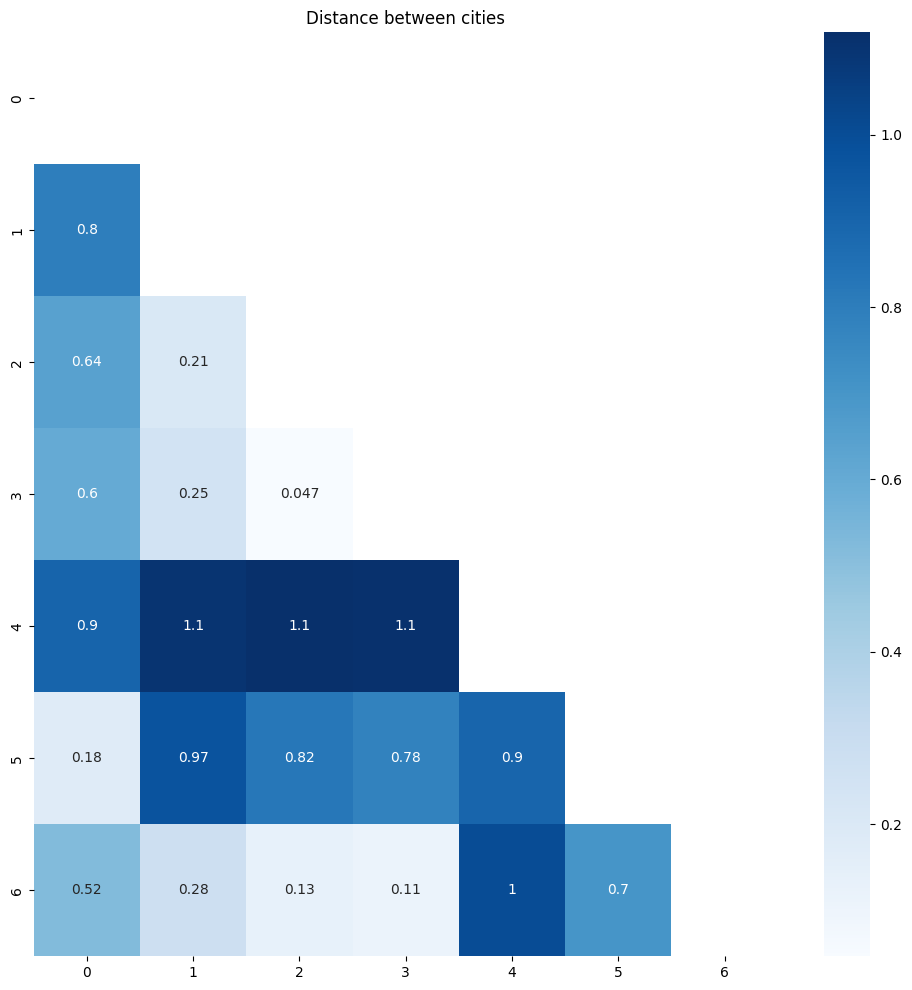

In [4]:
distances: np.ndarray = np.array([[get_distance_between_cities(cities[i], cities[j]) for j in range(CITIES)] for i in range(CITIES)])

# plot the distance between cities (using heatmap)
plt.figure(figsize=(12, 12))
mask = np.zeros_like(distances)  # create a mask
mask[np.triu_indices_from(mask)] = True  # apply the mask
sns.heatmap(distances, annot=True, mask=mask, cmap='Blues')  # plot heatmap
plt.title('Distance between cities')
plt.show()

### [Exhaustive Search](https://en.wikipedia.org/wiki/Exhaustive_search)

We implement a program that generates all possible solutions for the TSP using two algorithms, namely the **Heap algorithm** and the **Steinhaus–Johnson–Trotter algorithm**. By examining the complete solution space, we aim to evaluate the computational feasibility of exhaustively solving TSP for a given number of cities.

- Time Complexity: $O(n!)$
- Space Complexity: $O(n)$

New best solution found: (0, 1, 2, 3, 5, 4, 6) with fitness 3.737971774359478
New best solution found: (0, 1, 2, 3, 5, 6, 4) with fitness 3.5374600728727446
New best solution found: (0, 1, 2, 3, 6, 4, 5) with fitness 3.0686265428793424
New best solution found: (0, 1, 2, 3, 6, 5, 4) with fitness 2.7653953373024835
New best solution found: (0, 3, 2, 1, 6, 5, 4) with fitness 2.737256489008483
New best solution found: (0, 5, 1, 2, 3, 6, 4) with fitness 2.52070800618682
New best solution found: (0, 5, 3, 2, 1, 6, 4) with fitness 2.4981881613788914
New best solution found: (0, 5, 4, 6, 3, 2, 1) with fitness 2.449162254786574
New best solution found: (0, 5, 6, 2, 3, 1, 4) with fitness 2.4118150433653467
New best solution found: (0, 5, 6, 3, 2, 1, 4) with fitness 2.3440140105288156
New best solution found: (1, 2, 3, 6, 0, 5, 4) with fitness 1.9691658800834448
New best solution found: (4, 5, 0, 6, 3, 2, 1) with fitness 1.9691658800834446


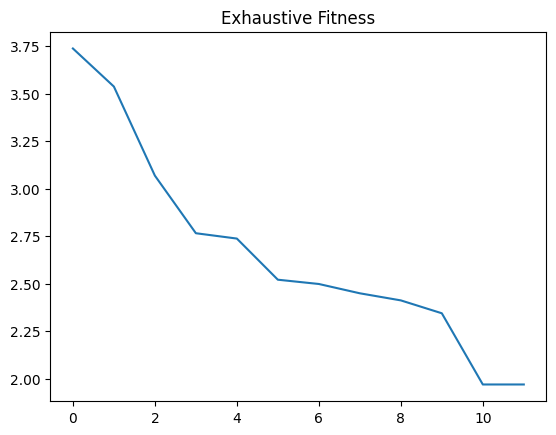

In [5]:
def exhaustive_search(cities: np.ndarray) -> tuple[np.ndarray, list[float]]:
    """Exhaustive search algorithm."""
    best_solution: np.ndarray = np.arange(CITIES)
    best_fitness = get_fitness(cities, best_solution)
    all_fitnesses = []  # list that will contain all fitnesses (for plotting)

    for solution in itertools.permutations(np.arange(CITIES)):
        fitness = get_fitness(cities, solution)
        if fitness < best_fitness:  # if new best solution is found
            all_fitnesses.append(fitness)
            print(f"New best solution found: {solution} with fitness {fitness}")
            best_fitness = fitness  # update best fitness
            best_solution = solution  # type: ignore # update best solution
    return (best_solution, all_fitnesses)  # return best solution

exhaustive_solution = exhaustive_search(cities)  # run exhaustive search
plot_fitness("Exhaustive Fitness", exhaustive_solution[1])  # plot fitness

Solution:  (4, 5, 0, 6, 3, 2, 1)
Distance: 1.9691658800834446
1 -> 4: 0.9008882726357317
4 -> 5: 0.17940860162767253
5 -> 0: 0.5236114020227279
0 -> 6: 0.11080747504308125
6 -> 3: 0.04684467492065958
3 -> 2: 0.20760545383357173


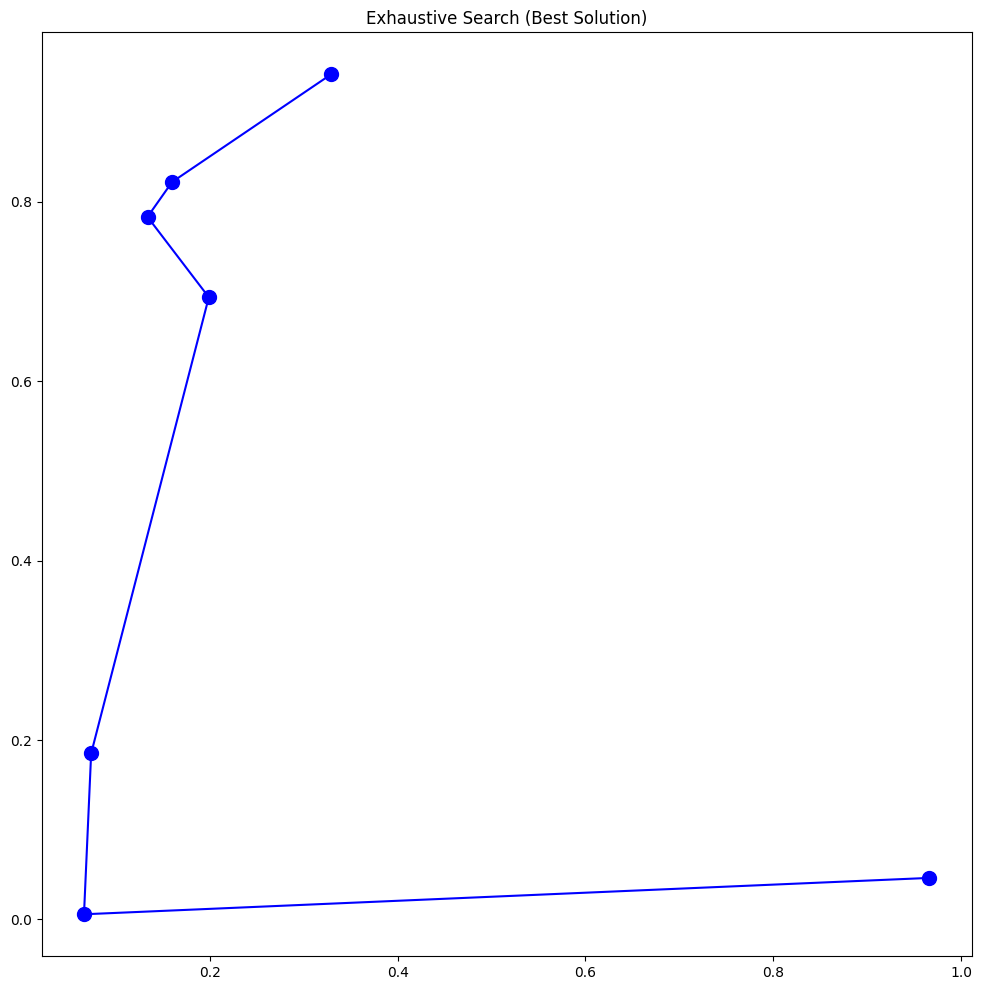

In [6]:
print_distances(cities, exhaustive_solution[0])  # print distances
plot_solution("Exhaustive Search (Best Solution)", cities, exhaustive_solution[0])  # plot solution

#### [Heap's Algorithm](https://en.wikipedia.org/wiki/Heap%27s_algorithm)

The Heap's Algorithm constructs all possible permutations of $n$ objects. It is a **[recursive](https://en.wikipedia.org/wiki/Recursion_(computer_science))** algorithm that generates each permutation from the previous one by choosing two elements to interchange.

The algorithm generates each permutation from the previous one by choosing two elements to interchange. The number of permutations of $n$ objects is $n!$.

The algorithm is named after [B. R. Heap](https://en.wikipedia.org/wiki/B._R._Heap), who published it in 1963, but it was first proposed by [Johnson](https://en.wikipedia.org/wiki/Johnson%27s_algorithm) in 1962.

See also the [original paper](https://watermark.silverchair.com/6-3-293.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAsIwggK-BgkqhkiG9w0BBwagggKvMIICqwIBADCCAqQGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM2W6w8Xqw0-17kz6lAgEQgIICdfPrsgBP0Cgc2wbMXjRGZhPqXfo5Z4GsCedCurL8Y4XuYwb7PVR1rdZ7TZhm-vkY5k9MU2Q90HgAIrxFG6Yt8cSVjC9rbnFPTDs5DHqHHSdxk9FrWBAdQQNovxrOcaXDJR3vFGUNhfiYDFlt1lAyOYLgGVsS83R74vj9Bm9QLX_tT_INwtbwQGtzE59EH9621_iMnDmkmMqZsKiOyclGHqMaROeVJs_-WUrW3oGE5BvjeM52Zs1k4Xe6pPVIsHhRg3Af00RYSRr3Q74ti0jvhewdseR73sJtsypApAb4YNsOxN4-Vk60L82GXMjAdDo2_CtRMnYXIWr_RwmWspFhsUXnHmwahS_uunBvfTm-76EhPOn0h8Sqjnf8baWfmDDNFf4xSr1o7F1Fxj6f6iyxZp3b0dAlMhxqhVS5PIwHtZwQXMejDUBK5X-Wh2ZxV7UH-zDK-H6rSFppNnssxJxz2TIZ7xQpdPbD6l64BnFRBWkogS2bbZ6m_z-blyjEeeKblNGr8HPT6kw7sEj6_4I7OKtKW54REcR5SFhWibWK1_QQkl-ammMyjSm7P4HMqjJVuifYL2rnKPVYtyT73r2buCbeVB6t6wG1iloyOq-0cPumL8su53hkqq7_5VlkMmoRM4pAIN2NIV27eYymLMgmx9Ku1wEgP0q9JHE-11T_TqxZGuHt5f9-R6JtFD-Ms9qkAoQOoSJFp88-5zeJWTa2wU4jokIrh_QwJVcPT39xR7Q5Qb1pXQLFzZ9d80RVioVfiePH98l81o6yW-BqHW2Q0rSfCLuoYSoru4Im06m_1C-jc9r9UCXS5SsYb_it5A5BCD4Z2Ylv) pdf. 

In [7]:
def heap_permutations(cities: np.ndarray, size: int) -> np.ndarray:
    permutations = []  # List to store permutations

    # Auxiliar function to generate all permutations of a list
    def generate_permutations(cities: np.ndarray, n: int) -> None:
        if n != 1:  # if size is not 1 then generate all permutations of size n-1
            for i in range(n):  # One by one move all characters from first to last
                generate_permutations(cities, n - 1)  # call itself to recursively to gen permutations
                if n % 2 == 0:  # if n is even swap ith and last element
                    cities[i], cities[n - 1] = cities[n - 1], cities[i]
                else:  # If n is odd swap first and last element
                    cities[0], cities[n - 1] = cities[n - 1], cities[0]
        else: permutations.append(cities.copy())  # If size is 1 then append the obtained permutation

    generate_permutations(cities.copy(), size)  # Generate all permutations of cities
    return np.array(permutations)  # Return permutations as a numpy array

solution = np.arange(CITIES)
permutations = heap_permutations(cities, len(solution))

In [8]:
# print_distances(cities, heap_solution)
# plot_solution("Heap's Algorithm (A good solution)", cities, heap_solution)

#### [SJT Algorithm](https://en.wikipedia.org/wiki/Steinhaus%E2%80%93Johnson%E2%80%93Trotter_algorithm)

The Steinhaus-Johnson-Trotter (SJT) algorithm is a **[recursive](https://en.wikipedia.org/wiki/Recursion_(computer_science))** algorithm that generates each permutation from the previous one by choosing two elements to interchange.

The algorithm generates each permutation from the previous one by choosing two elements to interchange. The number of permutations of $n$ objects is $n!$.

The algorithm is named after [Hugo Steinhaus](https://en.wikipedia.org/wiki/Hugo_Steinhaus), [Selmer M. Johnson](https://en.wikipedia.org/wiki/Selmer_M._Johnson), and [Hale F. Trotter](https://en.wikipedia.org/wiki/Hale_F._Trotter), who published it in 1963, but it was first proposed by [Johnson](https://en.wikipedia.org/wiki/Johnson%27s_algorithm) in 1962.

In [9]:
LEFT_TO_RIGHT = True  # LEFT TO RIGHT direction
RIGHT_TO_LEFT = False  # RIGHT TO LEFT direction

# Utility functions for finding the position of largest mobile integer in a[].
def searchArr(a, n, mobile) -> int: # type: ignore
	for i in range(n):
		if a[i] == mobile:
			return i + 1

# To carry out step 1 of the algorithm i.e. to find the largest mobile integer.
def getMobile(a, dir, n):
	mobile_prev = 0
	mobile = 0
	for i in range(n):
		# direction 0 represents RIGHT TO LEFT.
		if dir[a[i] - 1] == RIGHT_TO_LEFT and i != 0:
			if a[i] > a[i - 1] and a[i] > mobile_prev:
				mobile = a[i]
				mobile_prev = mobile
		# direction 1 represents LEFT TO RIGHT.
		if dir[a[i] - 1] == LEFT_TO_RIGHT and i != n - 1:
			if a[i] > a[i + 1] and a[i] > mobile_prev:
				mobile = a[i]
				mobile_prev = mobile
	if mobile == 0 and mobile_prev == 0:
		return 0
	else:
		return mobile

# Prints a single permutation
def printOnePerm(a, dir, n):
	mobile = getMobile(a, dir, n)
	pos: int = searchArr(a, n, mobile)

	# swapping the elements according to the direction i.e. dir[]
	if dir[a[pos - 1] - 1] == RIGHT_TO_LEFT: a[pos - 1], a[pos - 2] = a[pos - 2], a[pos - 1]
	elif dir[a[pos - 1] - 1] == LEFT_TO_RIGHT: a[pos], a[pos - 1] = a[pos - 1], a[pos]
	for i in range(n):  # changing the directions for elements greater than largest mobile integer
		if a[i] > mobile:
			if dir[a[i] - 1] == LEFT_TO_RIGHT: dir[a[i] - 1] = RIGHT_TO_LEFT
			elif dir[a[i] - 1] == RIGHT_TO_LEFT: dir[a[i] - 1] = LEFT_TO_RIGHT
	for i in range(n): print(a[i], end='')
	print("")

# To end the algorithm for efficiency it ends at the factorial of n because number of permutations possible is just n!.
def fact(n):
	res = 1
	for i in range(1, n + 1): res = res * i
	return res

# This function mainly calls printOnePerm() one by one to print all permutations.
def printPermutation(n):
	# To store current permutation storing the elements from 1 to n and
	a = [i + 1 for i in range(n)]

	# Printing the first permutation
	for i in range(n): print(a[i], end='')
	print("")
	# To store current directions initially all directions are set to RIGHT TO LEFT i.e. 0.
	dir = [RIGHT_TO_LEFT for i in range(n)]
	# for generating permutations in the order.
	for i in range(1, fact(n)): printOnePerm(a, dir, n)

# Driver code
n = 4
printPermutation(n)

1234
1243
1423
4123
4132
1432
1342
1324
3124
3142
3412
4312
4321
3421
3241
3214
2314
2341
2431
4231
4213
2413
2143
2134


### [Random Search](https://en.wikipedia.org/wiki/Random_search)

Random Search is a simple **[stochastic](https://en.wikipedia.org/wiki/Stochastic)** optimization algorithm that does not use any information about the problem to find the solution. It is a **[Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method)** method that randomly samples the search space to find the solution.

New best solution found: [3 0 1 2 4 6 5] with fitness 4.430129491185665
New best solution found: [2 3 0 5 6 1 4] with fitness 2.907142598121684
New best solution found: [0 5 4 1 2 6 3] with fitness 2.631934985915606


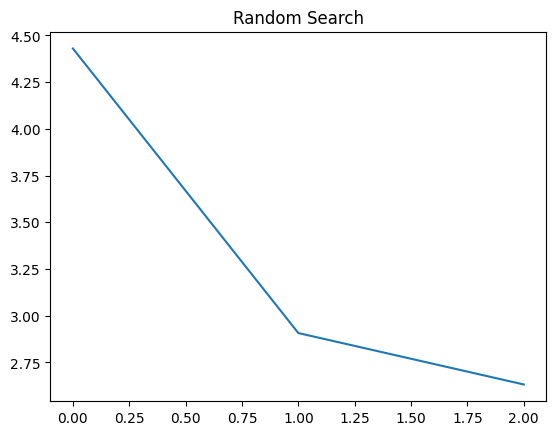

In [26]:
def random_search(cities: np.ndarray, iterations: int = 100) -> tuple[np.ndarray, list[float]]:
    """
    Random Search Algorithm is a simple one. Just generate a random solution and check if it is better than the best solution found so far.
    If it is, then update the best solution. Repeat this process for a given number of iterations.

    ### Parameters:
        cities: np.ndarray - The cities to visit.
        iterations: int - The number of iterations to run the algorithm for.

    ### Returns:
        np.ndarray - The best solution found.
    """
    best_fitness = np.inf
    best_solution = np.arange(CITIES)

    all_fitnesses = []  # list to store all fitnesses
    for _ in range(iterations):  # for each iteration
        solution = np.random.permutation(CITIES)
        fitness = np.sum([get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)])
        if fitness < best_fitness:
            all_fitnesses.append(fitness)  # add fitness to list
            print(f"New best solution found: {solution} with fitness {fitness}")
            best_fitness = fitness
            best_solution = solution  # update best solution
    return (best_solution, all_fitnesses)  # return best solution

random_solution = random_search(cities, 10)  # just run for 10 iterations (for the sake of time)

plot_fitness("Random Search", random_solution[1])  # plot the fitnesses

Solution:  [0 5 4 1 2 6 3]
Distance: 2.631934985915606
3 -> 0: 0.17940860162767253
0 -> 5: 0.9008882726357317
5 -> 4: 1.0989712339548319
4 -> 1: 0.20760545383357173
1 -> 2: 0.13425394882071665
2 -> 6: 0.11080747504308125


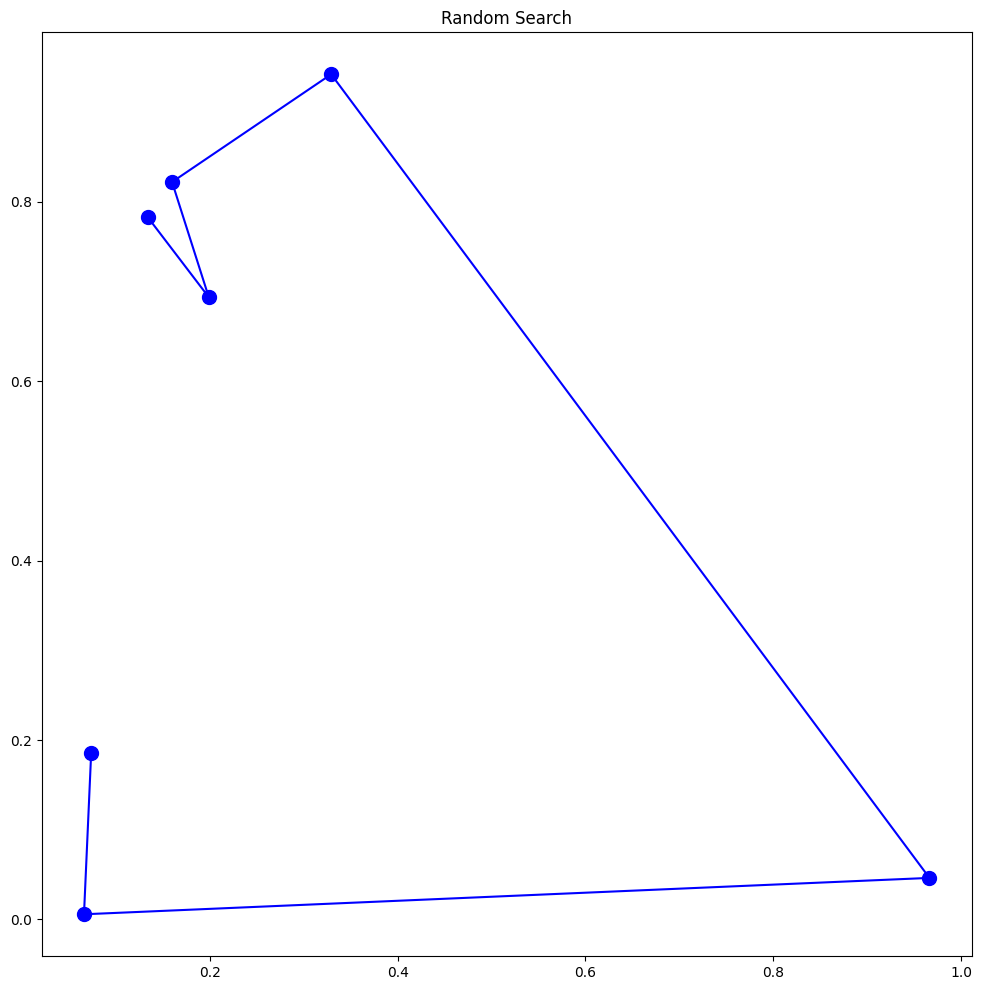

In [27]:
print_distances(cities, random_solution[0])
plot_solution("Random Search", cities, random_solution[0])

### [Hill Climbing Search](https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/)

Is a heuristic search used for mathematical optimization problems in the field of Artificial Intelligence.

Given a large set of inputs and a good heuristic function, it tries to find a sufficiently good solution to the problem. This solution may not be the global optimal maximum.

**Steps:**

2. At each iteration, the algorithm selects a pair of edges and checks if swapping them leads to a shorter total distance.
3. If a shorter distance is found, the swap is performed, and the process continues with the modified solution.
4. This process is repeated until no further improvement is possible, and a local optimum is reached.

Initial distance:  68.8247314366978


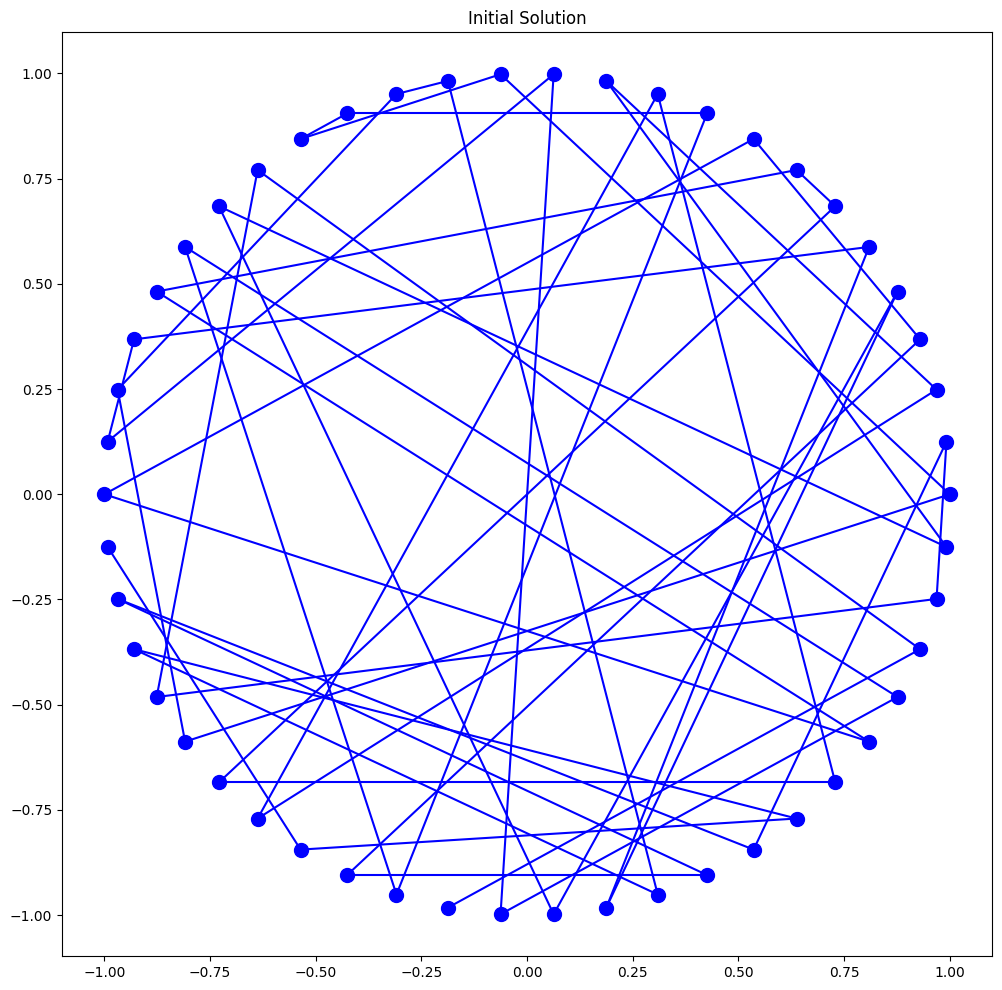

In [24]:
n_cities = 50
city_list = np.array([[np.cos(2 * np.pi * i / n_cities), np.sin(2 * np.pi * i / n_cities)] for i in range(n_cities)])
# city_list = generate_cities(50)  # generate cities

distance_calculation = lambda r, c: np.sum([np.linalg.norm(c[r[i]] - c[r[i - 1]]) for i in range(len(r))])
# where r is the route and c is the city list

swap_algorithm = lambda r, i, k: np.concatenate((r[0:i], r[k:i - 1:-1], r[k + 1:len(r)]))
# where r is the route, i is the first city to swap and k is the second city to swap

solution = np.random.permutation(len(city_list))  # generate random solution
print('Initial distance: ', distance_calculation(solution, city_list))
plot_solution("Initial Solution", city_list, solution)

#### Hill Climbing 2 Opt

1. It's performed by **considering pairs of edges** in the current solution.

In [18]:
def hill_climbing_2_opt(solution, city_list):
    """
    Hill Climbing - 2 Opt Algorithm makes small changes to the solution and checks if the new solution is better than the old solution.
    """
    current_best_distance = distance_calculation(solution, city_list)  # calculate the distance
    for swap_1 in range(1, len(solution) - 2):  # for each city except the first and last
        for swap_2 in range(swap_1 + 1, len(solution) - 1):  # for each city except the last
            new_solution = swap_algorithm(solution, swap_1, swap_2)  # swap the cities
            new_distance = distance_calculation(new_solution, city_list)  # calculate the distance
            if new_distance < current_best_distance:  # if the new distance is better than the old distance
                solution = new_solution  # update the solution
                current_best_distance = new_distance  # update the distance
                # print('new best distance: ', current_best_distance)
    return np.array(solution)

Travelled distance: 13.673467984766184


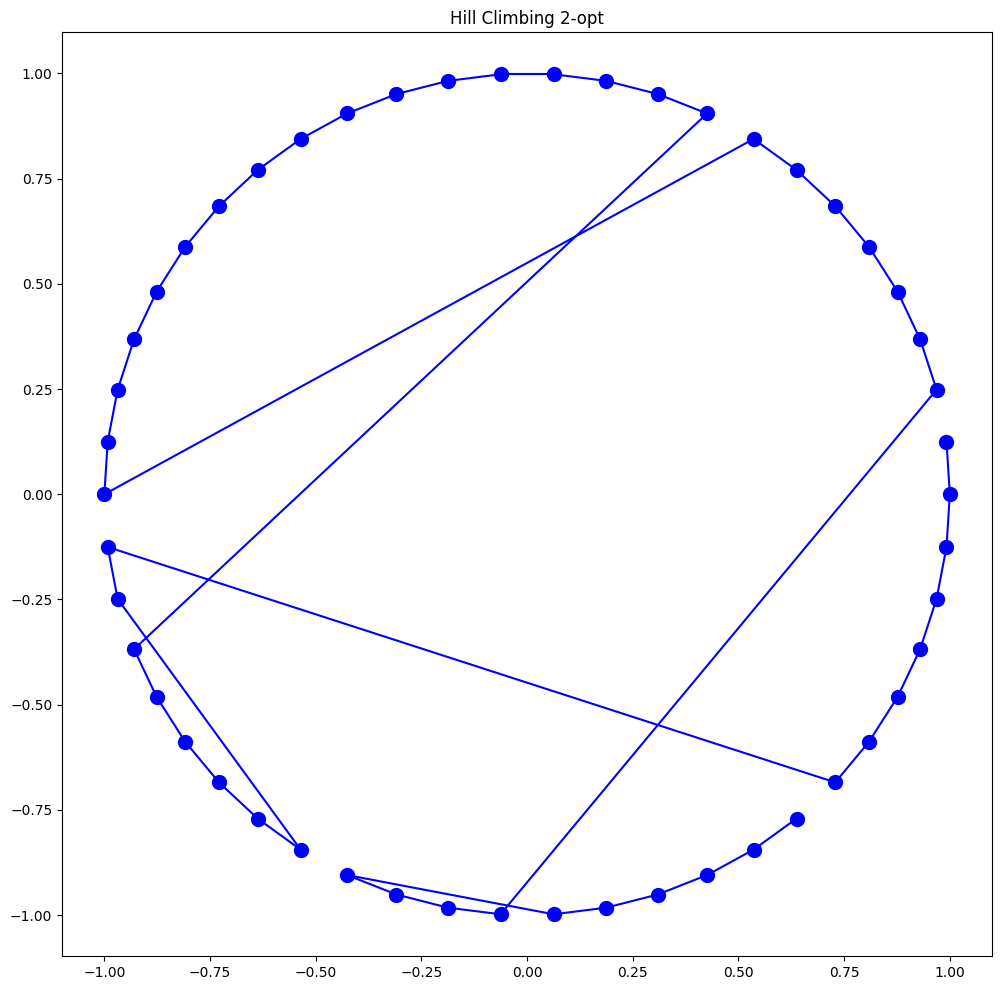

In [22]:
hill_climbing_2_solution = solution.copy()  # copy the solution
hill_climbing_2_solution = hill_climbing_2_opt(hill_climbing_2_solution, city_list)  # run the algorithm

# print_distances(city_list, hill_climbing_2_solution)  # print the distances
print(f"Travelled distance: {sum([get_distance_between_cities(city_list[hill_climbing_2_solution[i]], city_list[hill_climbing_2_solution[i + 1]]) for i in range(len(city_list) - 1)])}")
plot_solution("Hill Climbing 2-opt", city_list, hill_climbing_2_solution)  # plot the solution

#### Hill Climbing 3 Opt

1. The Opt3 algorithm expands on the Opt2 algorithm by considering triplets of edges in the current solution.

In [15]:
def hill_climbing_3_opt(solution, city_list):
    """
    Hill Climbing - 3 Opt Algorithm makes small changes to the solution and checks if the new solution is better than the old solution.
    """
    current_best_distance = distance_calculation(solution, city_list)
    for swap_1 in range(1, len(solution) - 3):
        for swap_2 in range(swap_1 + 1, len(solution) - 2):
            for swap_3 in range(swap_2 + 1, len(solution) - 1):
                new_solution = swap_algorithm(solution, swap_1, swap_3)
                new_distance = distance_calculation(new_solution, city_list)
                if new_distance < current_best_distance:
                    solution = new_solution
                    current_best_distance = new_distance
                    # print('new best distance: ', current_best_distance)
    return np.array(solution)

Travelled distance: 8.52121601858656


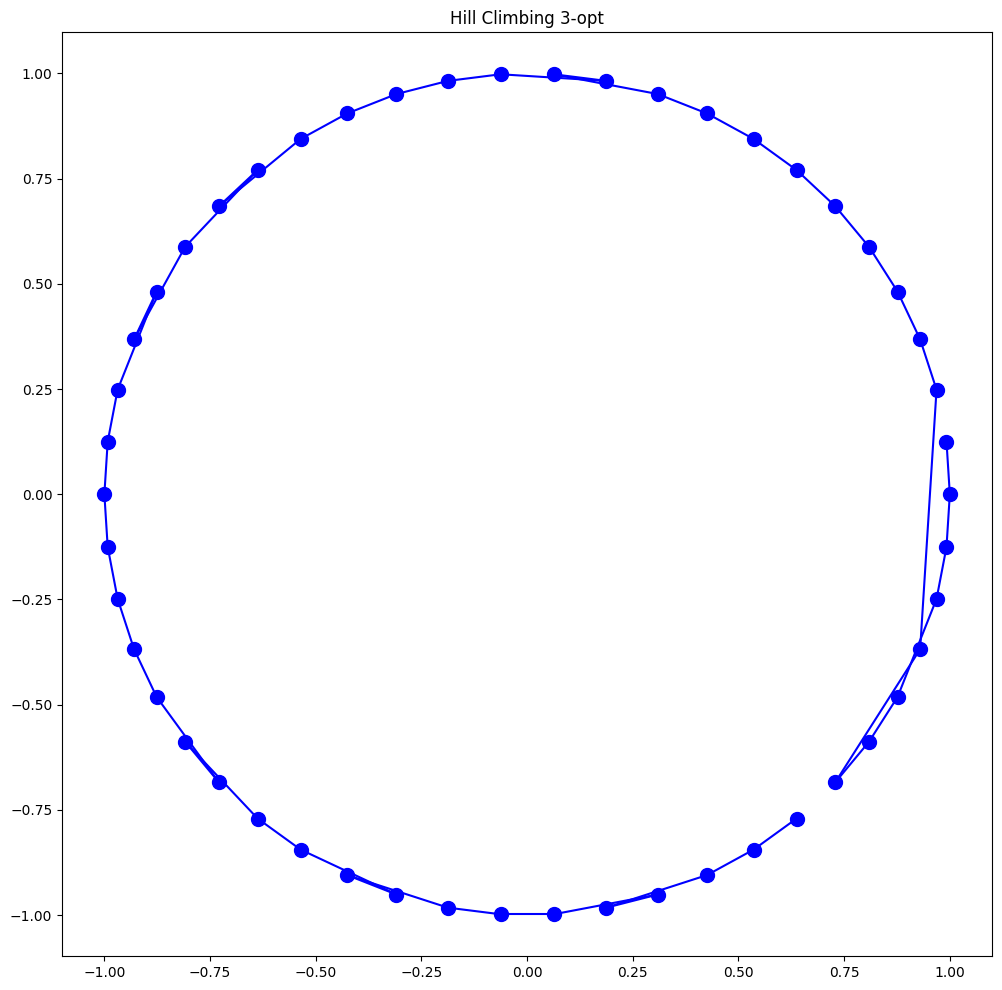

In [23]:
hill_climbing_3_solution = solution.copy()  # copy the solution
hill_climbing_3_solution = hill_climbing_3_opt(hill_climbing_3_solution, city_list)  # run the algorithm

# print_distances(city_list, hill_climbing_3_solution)  # print the distances
print(f"Travelled distance: {sum([get_distance_between_cities(city_list[hill_climbing_3_solution[i]], city_list[hill_climbing_3_solution[i + 1]]) for i in range(len(city_list) - 1)])}")
plot_solution("Hill Climbing 3-opt", city_list, hill_climbing_3_solution)  # plot the solution